In [1]:
import numpy as np
import pandas as pd
import itertools
import warnings
import statsmodels.api as sm
import matplotlib.pyplot as plt
from tqdm import tqdm

class ManualARIMA:
    def __init__(self, data, p_range=(0, 4), d_range=(0, 2), q_range=(0, 2), seasonal=12, split_ratio=0.8):
        self.data = data
        self.split_ratio = split_ratio
        self.seasonal = seasonal

        # Define the p, d, q parameters
        p = range(*p_range)
        d = range(*d_range)
        q = range(*q_range)

        # Generate all different combinations of p, d, q triplets
        self.pdq = list(itertools.product(p, d, q))
        # Generate all different combinations of seasonal p, d, q triplets
        self.seasonal_pdq = [(x[0], x[1], x[2], seasonal) for x in list(itertools.product(p, d, q))]

        self.train_data = self.data[:int(len(data) * split_ratio)]
        self.test_data = self.data[int(len(data) * split_ratio):]

    def fit(self):
            warnings.filterwarnings("ignore")

            AIC = []
            SARIMAX_model = []
            total_iter = len(self.pdq) * len(self.seasonal_pdq)
            with tqdm(total=total_iter, desc="Fitting Model", unit="iteration") as pbar:

                for param in self.pdq:
                    for param_seasonal in self.seasonal_pdq:
                        try:
                            mod = sm.tsa.statespace.SARIMAX(self.train_data,
                                                            order=param,
                                                            seasonal_order=param_seasonal,
                                                            enforce_stationarity=False,
                                                            enforce_invertibility=False)

                            results = mod.fit()

                            AIC.append(results.aic)
                            SARIMAX_model.append([param, param_seasonal])
                        except:
                            continue
                        finally:
                            pbar.update(1)

            best_model = SARIMAX_model[AIC.index(min(AIC))]
            self.results = sm.tsa.statespace.SARIMAX(self.train_data,
                                                    order=best_model[0],
                                                    seasonal_order=best_model[1],
                                                    enforce_stationarity=False,
                                                    enforce_invertibility=False).fit()

    def plot_diagnostics(self, figsize=(12, 8)):
        self.results.plot_diagnostics(figsize=figsize)
        plt.show()

    def predict(self, start, end, dynamic=False):
        pred = self.results.get_prediction(start=start, end=end, dynamic=dynamic)
        pred_ci = pred.conf_int()
        return pred.predicted_mean, pred_ci

    def forecast(self, steps):
        pred = self.results.get_forecast(steps=steps)
        pred_ci = pred.conf_int()
        return pred.predicted_mean, pred_ci

    def plot_forecast(self, start, end, steps=12):
        predicted_mean, pred_ci = self.predict(start, end)
        forecasted_mean, forecast_ci = self.forecast(steps)

        plt.figure(figsize=(10, 6))
        plt.plot(self.data, label='Observed')
        plt.plot(predicted_mean, color='red', label='Forecast')
        plt.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.1)

        forecast_index = pd.date_range(start=pred_ci.index[-1], periods=steps, freq='B')
        plt.plot(forecast_index, forecasted_mean, color='green', label='Future Forecast')
        plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='k', alpha=.1)

        plt.title('Stock Price Forecast')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.show()


[*********************100%%**********************]  1 of 1 completed


Fitting Model: 100%|██████████| 64/64 [00:27<00:00,  2.36iteration/s]


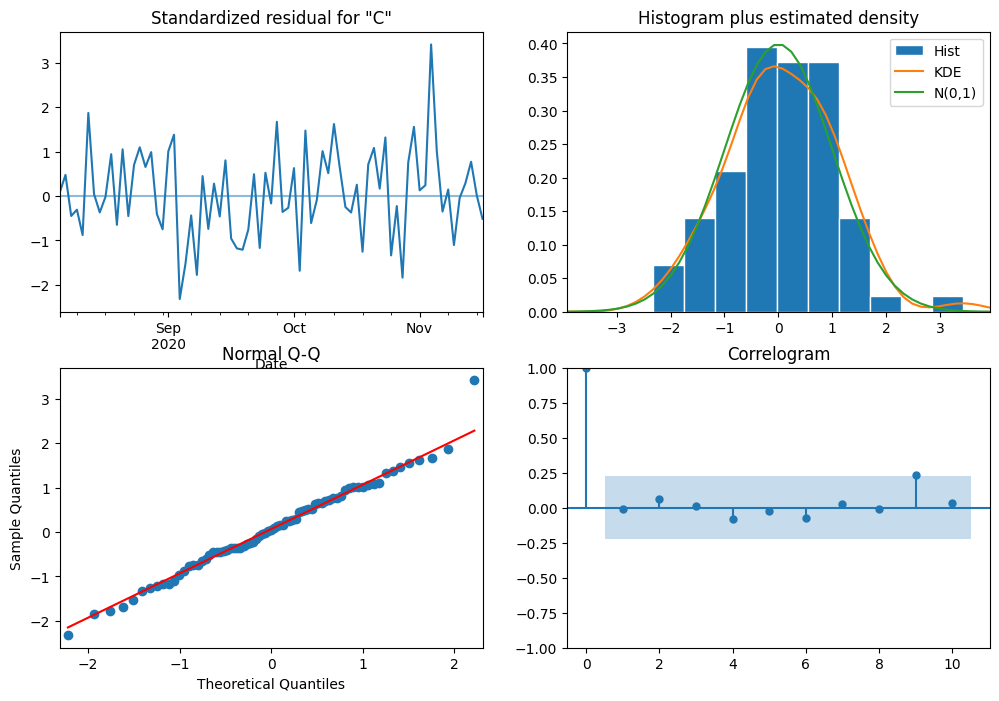

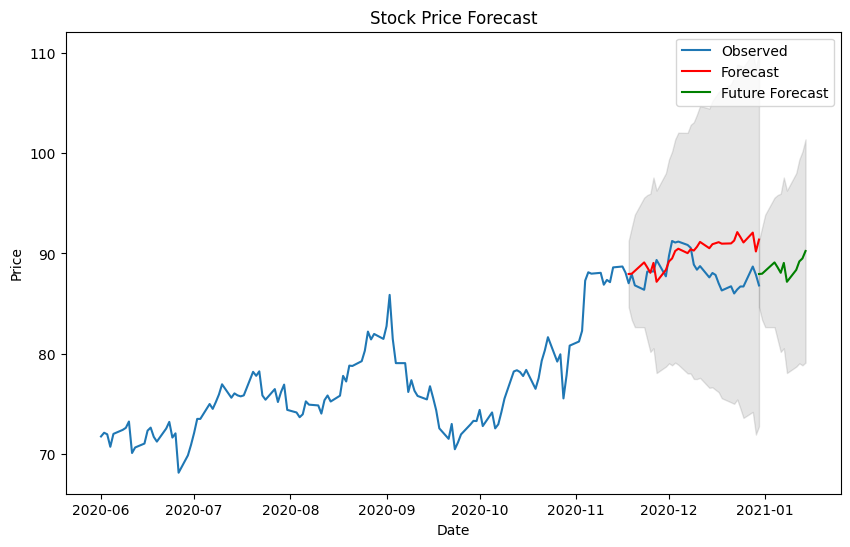

In [3]:
import yfinance as yf
# Step 1: download data with yfinance
ticker = 'GOOGL'
data = yf.download(ticker, start="2020-06-01", end="2020-12-31")['Close']
data = data.asfreq('B').fillna(method='ffill')

# Step 2: fit ManualARIMA
manual_arima = ManualARIMA(data, p_range=(0, 2), d_range=(0, 2), q_range=(0, 2), seasonal=22, split_ratio=0.8)
manual_arima.fit()

# Step 3: Plot Diagnostics and Forecast
manual_arima.plot_diagnostics()
start_date = data.index[int(len(data) * 0.8)]
end_date = data.index[-1]
manual_arima.plot_forecast(start=start_date, end=end_date, steps=12)